In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

.\data\items.csv
.\data\item_categories.csv
.\data\sales_train.csv
.\data\sample_submission.csv
.\data\shops.csv
.\data\test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

sns.set_style('darkgrid')

Using TensorFlow backend.


In [4]:
path = '/kaggle/input/competitive-data-science-predict-future-sales/'
items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
sales_train = pd.read_csv(path+'sales_train.csv')
shops = pd.read_csv(path+'shops.csv')
test = pd.read_csv(path+'test.csv')

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


num_item_id: 2935849
unique_item_id: 21807


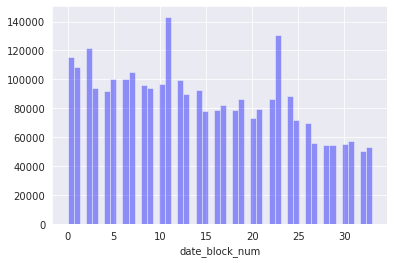

In [60]:
sns.distplot(a=sales_train.date_block_num,kde=False,color='b')
print('num_item_id: %d'%(sales_train.item_id.size))
print('unique_item_id: %d'%(sales_train.item_id.unique().size))

In [85]:
item_cat = pd.Series(data=items.item_category_id,index=items.item_id,name='item_category_id')
item_cat = sales_train.item_id.map(lambda p:item_cat[p])
item_cat.name = 'item_category_id'
sales_train_new = pd.concat([sales_train,item_cat],axis=1)
i_num = sales_train_new.item_category_id.unique().size
s_num = sales_train_new.shop_id.unique().size
print('item_category_id_mun: %d'%i_num)
print('shop_id_mun: %d'%s_num)

i_mun: 84
s_mun: 60


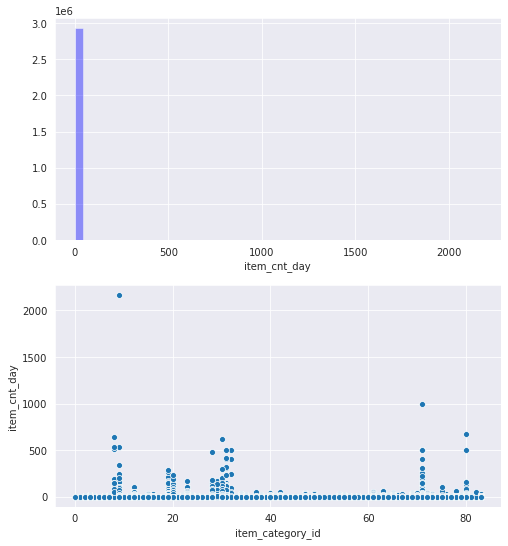

In [98]:
ind = (sales_train_new.item_cnt_day<10000) & (sales_train_new.item_cnt_day>0)

plt.figure(figsize=(8,9))
plt.subplot(2,1,1)
sns.distplot(a=sales_train_new[ind].item_cnt_day,kde=False,color='b')
plt.subplot(2,1,2)
sns.scatterplot(x='item_category_id',y='item_cnt_day',data=sales_train_new[ind])

sales_train.item_cnt_day[ind].describe()
sales_train_new = sales_train_new[ind]

In [162]:
ind2 = (sales_train_new.item_cnt_day>100)
sales_train_new[ind2]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
566159,11.06.2013,5,12,2808,999.000000,200.0,30
620237,14.06.2013,5,42,16787,2559.746729,107.0,19
836296,29.08.2013,7,12,2808,999.000000,150.0,30
845690,18.09.2013,8,42,3732,2521.211982,217.0,19
845703,18.09.2013,8,42,3734,2520.730769,104.0,23
...,...,...,...,...,...,...,...
2864262,28.09.2015,32,12,9248,1500.000000,139.0,80
2864264,30.09.2015,32,12,9244,1296.273292,161.0,80
2909401,14.10.2015,33,12,20949,4.000000,500.0,71
2909818,28.10.2015,33,12,11373,0.908714,2169.0,9


In [171]:
print(items.iloc[16787])
item_categories.iloc[30]

item_name           Одни из нас [PS3, русская версия]
item_id                                         16787
item_category_id                                   19
Name: 16787, dtype: object


item_category_name    Игры - PS3
item_category_id              19
Name: 19, dtype: object

In [142]:
features = ['item_category_id','shop_id','item_id']

#index = []
#for i in range(i_num):
#    index += ['item_category_id_'+str(i)]

#for j in range(s_num):
#    index += ['shop_id_'+str(j)]
#encoder = OneHotEncoder()
#features_ec = encoder.fit_transform(sales_train_new[features]).toarray()
#features_ec = pd.DataFrame(features_ec,index=sales_train_new.index,columns=index)
#features_ec = features_ec.join(sales_train_new['date_block_num'])

## Target Encoder
target_enc = ce.TargetEncoder(cols = features)
features_ec = target_enc.fit_transform(sales_train_new[features],sales_train_new['item_cnt_day'])
features_ec = pd.DataFrame(features_ec,index=sales_train_new.index)
features_ec = features_ec.join(sales_train_new['date_block_num'])

## CatBoost Encoder
#catboost_enc = ce.CatBoostEncoder(cols = features)
#features_ec = catboost_enc.fit_transform(sales_train_new[features],sales_train_new['item_cnt_day'])
#features_ec = pd.DataFrame(features_ec,index=sales_train_new.index)
#features_ec = features_ec.join(sales_train_new['date_block_num'])

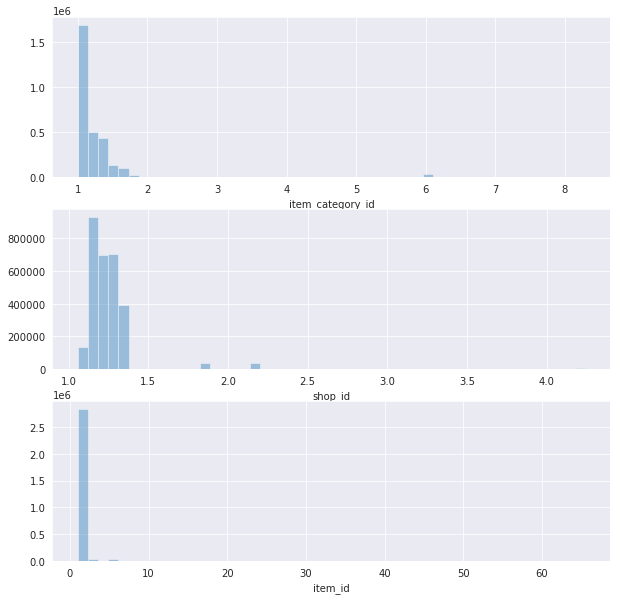

In [143]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
sns.distplot(a=features_ec.item_category_id,kde=False)
plt.subplot(3,1,2)
sns.distplot(a=features_ec.shop_id,kde=False)
plt.subplot(3,1,3)
sns.distplot(a=features_ec.item_id,kde=False)
plt.show()

In [140]:
X = features_ec
Y = sales_train_new['item_cnt_day']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [130]:
def rmse(y_true,y_pred):
    return K.sqrt(K.mean(K.square((y_true-y_pred))))

In [141]:
model = Sequential()
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
#model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(loss='mse',optimizer='adam',metrics=[rmse])
model.fit(np.array(x_train),np.array(y_train),validation_data=(np.array(x_test),np.array(y_test)),epochs=5,batch_size=5000)

Train on 2342794 samples, validate on 585699 samples
Epoch 1/5
2342794/2342794 [==============================] - 5s 2us/step - loss: 7.0474 - rmse: 1.8774 - val_loss: 3.6475 - val_rmse: 1.6228
Epoch 2/5
2342794/2342794 [==============================] - 4s 2us/step - loss: 6.9735 - rmse: 1.8661 - val_loss: 3.6713 - val_rmse: 1.6305
Epoch 3/5
2342794/2342794 [==============================] - 5s 2us/step - loss: 6.9642 - rmse: 1.8715 - val_loss: 3.6310 - val_rmse: 1.6166
Epoch 4/5
2342794/2342794 [==============================] - 5s 2us/step - loss: 6.9615 - rmse: 1.8658 - val_loss: 3.6344 - val_rmse: 1.6179
Epoch 5/5
2342794/2342794 [==============================] - 4s 2us/step - loss: 6.9552 - rmse: 1.8638 - val_loss: 3.8457 - val_rmse: 1.6906


In [82]:
del model

In [133]:
x_train

,item_category_id,shop_id,item_id,date_block_num
2039459,1.624719,1.264951,1.903158,21
2048818,1.167001,2.159409,1.098655,21
1687193,1.303808,1.242558,1.162907,16
2113171,1.098375,1.185675,1.241958,22
1956137,1.233325,1.185057,1.106207,20
...,...,...,...,...
2822405,1.064949,1.323341,1.011050,31
2454076,1.125806,1.156484,1.206667,25
1898630,1.444921,1.149296,1.133333,19
164188,1.125806,1.156120,1.000000,1
